In [1]:
import pandas as pd
import numpy as np
import glob
import os



import matplotlib.pyplot as plt

In [2]:
path_files = r'./tirages/*.csv'

In [3]:
all_files = glob.glob(path_files)





#filename = all_files[0]

df_list = []

for filename in all_files:
    df = pd.read_csv(filename, sep=';', parse_dates=['date_de_tirage'], dayfirst=True)
    
    df = df[["date_de_tirage", "boule_1", "boule_2", "boule_3", "boule_4", "boule_5", "numero_chance"]]
    
    df.rename(columns={
        'date_de_tirage': 'date_tirage',
        'boule_1': 'num0',
        'boule_2':'num1', 
        "boule_3": "num2", 
        "boule_4": "num3", 
        "boule_5": "num4", 
        "numero_chance": "chance"},inplace=True)
    print(df.shape)
    df_list.append(df)
    #break;

df = pd.concat(df_list)

# placer le dernier tirage en dernière position
df.sort_values('date_tirage', ascending = True, inplace=True)
df.shape

(4858, 7)
(310, 7)
(107, 7)
(455, 7)
(1317, 7)


(7047, 7)

In [5]:
df = df[["date_tirage", "num0"]]

tdi = pd.DatetimeIndex(df.date_tirage)
df.set_index(tdi, inplace=True)
df.drop(columns='date_tirage', inplace=True)
df.index.name = 'datetimeindex'

df.head()

,num0
datetimeindex,
1976-05-19,31
1976-06-03,10
1976-06-10,44
1976-06-16,2
1976-06-23,30


In [6]:
df_2022 = df[(df.index > '2022-01-01')]

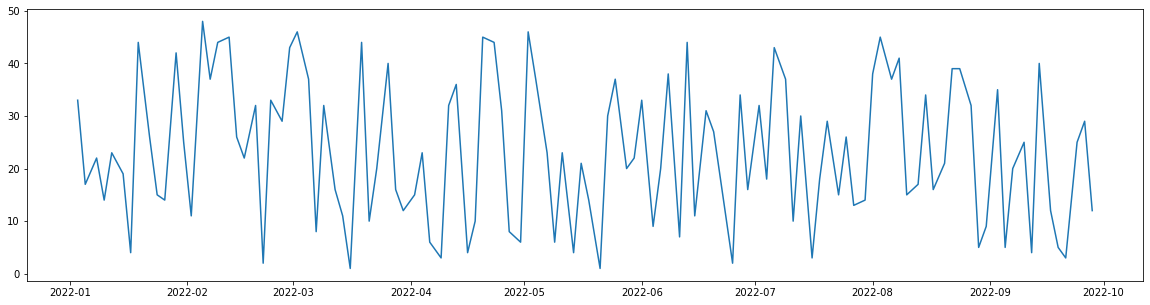

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df_2022)

plt.show();

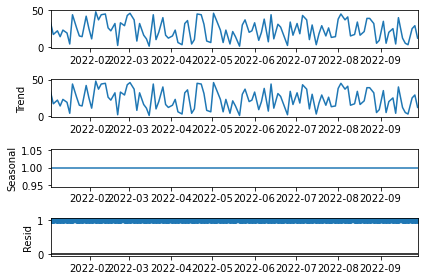

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df_2022, model='multiplicative', extrapolate_trend='freq', period=1) # additive

res.plot()
plt.show();

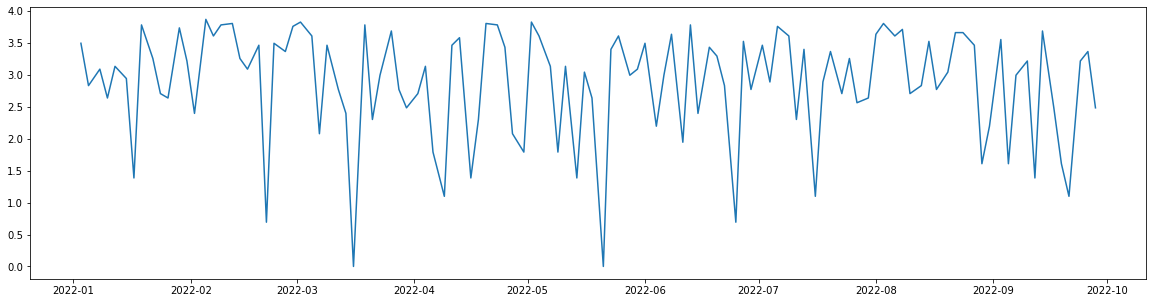

In [18]:
df_2022_log = np.log(df_2022)

plt.figure(figsize=(20,5))
plt.plot(df_2022_log)
plt.show()

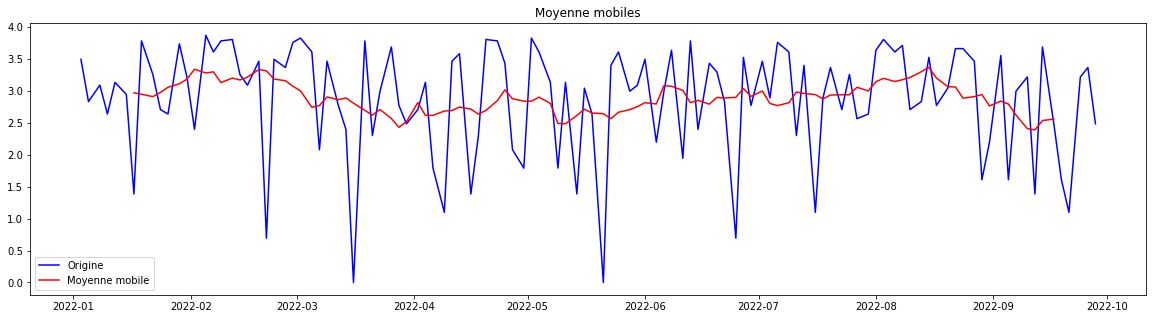

In [25]:
#saisonnalité de période 12
df_2022_ma = df_2022_log.rolling(window = 12, center = True).mean()


plt.figure(figsize=(20,5))
plt.plot(df_2022_log, color = 'blue', label = 'Origine')
plt.plot(df_2022_ma, color = 'red', label = 'Moyenne mobile')
plt.legend()
plt.title('Moyenne mobiles')
plt.show()

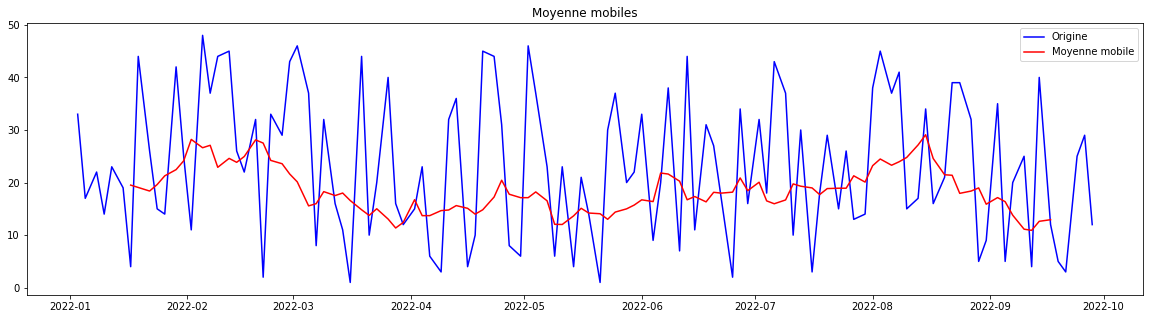

In [26]:
plt.figure(figsize=(20,5))
plt.plot(np.exp(df_2022_log), color = 'blue', label = 'Origine')
plt.plot(np.exp(df_2022_ma), color = 'red', label = 'Moyenne mobile')
plt.legend()
plt.title('Moyenne mobiles')
plt.show()

différence entre la série et sa moyenne mobile

In [28]:
df_2022_without_ma = df_2022_log - df_2022_ma
df_2022_without_ma = df_2022_without_ma.dropna()
df_2022_without_ma.head(10)

,num0
datetimeindex,
2022-01-17,-1.584798
2022-01-19,0.836233
2022-01-22,0.346416
2022-01-24,-0.268643
2022-01-26,-0.418624
2022-01-29,0.625930
2022-01-31,0.035284
2022-02-02,-0.941680
2022-02-05,0.589388


In [30]:
df_2022_without_ma['month'] = (df_2022_without_ma.index).month

df_2022_without_ma.head(10)

,num0,month
datetimeindex,,
2022-01-17,-1.584798,1
2022-01-19,0.836233,1
2022-01-22,0.346416,1
2022-01-24,-0.268643,1
2022-01-26,-0.418624,1
2022-01-29,0.625930,1
2022-01-31,0.035284,1
2022-02-02,-0.941680,2
2022-02-05,0.589388,2


Moyenne par mois à l'aide du groupby 

In [32]:
seasonnality = df_2022_without_ma.groupby('month').mean()

seasonnality = seasonnality - seasonnality.mean()

In [42]:
seasonnality.iloc[:,0]

month
1   -0.064881
2   -0.013000
3    0.046429
4   -0.114890
5    0.059699
6   -0.070789
7   -0.008895
8    0.058029
9    0.108299
Name: num0, dtype: float64

In [48]:
# Création du vecteur 

seasonal_vector = np.zeros(116)

j=0
for i in range(9):
    seasonal_vector[j:j+9] = seasonnality.iloc[:,0]
    j=j+9

print(df_2022_log.shape, seasonal_vector.shape)
    
# Soustraire les coefficients saisonniers
df_2022_log_cvs = df_2022_log - seasonal_vector.reshape(116,1)

# On retrouve la série originale par passage à l'exponentielle
df_2022_cvs = np.exp(df_2022_log_cvs)

(116, 1) (116,)


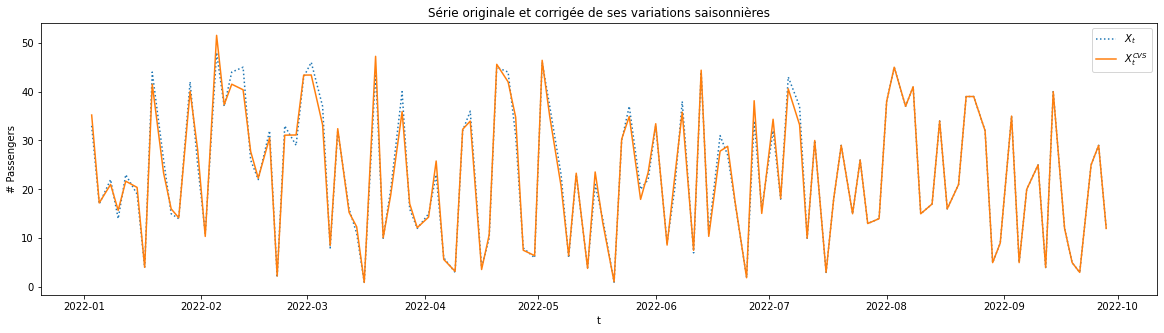

In [50]:
plt.figure(figsize=(20,5))
plt.plot(df_2022, ':', label = '$X_t$')
plt.plot(df_2022_cvs, label = '$X_t^{CVS}$')
plt.title('Série originale et corrigée de ses variations saisonnières')
plt.xlabel('t')
plt.ylabel('# Passengers')
plt.legend();